In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def ICV_rgb_to_greyscale(image):
    '''
    Image : Image in RBG that needs to be converted to greyscale
    Returns : The greyscale image of the RGB image
    '''
    #Array slicing to get all the channels
    normalized_image = image
    blue, green, red  = normalized_image[:, :, 0], normalized_image[:, :, 1], normalized_image[:, :, 2]
    red_const, green_const, blue_const = 0.3, 0.59, 0.11
    
    greyscale_image = red_const * red + \
                        green_const * green + \
                        blue_const * blue
    return greyscale_image

In [3]:
def ICV_load_video(filepath):
    capture = cv2.VideoCapture(filepath)
    frames = []
    
    while capture.isOpened():
    #Readiing a new frame
        ret, frame = capture.read()
        if ret == True:
            greyscale_frame = ICV_rgb_to_greyscale(frame)
            frames.append(greyscale_frame)
            #cv2.imshow("frame", frame)
            k = cv2.waitKey(1) & 0xff
    
        #Breaking the while loop if failed to read a new frame
        else:
            break

    capture.release()
    cv2.destroyAllWindows()
    return frames

In [4]:
filepath = "Dataset/DatasetC.avi"
frames = ICV_load_video(filepath)


In [5]:
def ICV_frame_difference(current_frame, reference_frame, classification_threshold, show_plot = False, name = None):
    '''
    param current_frame : The frame for which pixel by pixel frame difference have to be done
    param reference_frame : The reference for pixel by pixel frame differencing
    param classification_threshold : The the threshold for seperating background and objects
    param show_plot : Boolean value specifying if the plots have to be displayed or not
    param name : String to distinguish saved file names
    '''
    frame_difference = np.zeros((current_frame.shape[0], current_frame.shape[1]))
    
    for i in range(current_frame.shape[0]):
        for j in range(current_frame.shape[1]):
            frame_difference[i][j] = np.abs(current_frame[i][j] - reference_frame[i][j])       
            
    threshold_frames = ICV_threshold_frames(frame_difference, classification_threshold)
    if show_plot:
        plt.title("Frame differencing with {}".format(name))
        plt.axis("off")
        plt.imshow(frame_difference, cmap = "gray")
        plt.imsave("outputs/frame_difference {}.jpg".format(name), frame_difference, cmap = 'gray')
        plt.show()
        
        plt.title("Thresholding with {}".format(name))
        plt.axis("off")
        plt.imshow(threshold_frames, cmap = "gray")
        plt.show()
        
    return threshold_frames    

    
    

In [6]:
def ICV_threshold_frames(frame_difference, classification_threshold):
    '''
    param frame_differe : Pixel by pixel frame difference of all the frames and the reference frame
    param classification_threshold : The the threshold for seperating background and objects
    '''
    threshold_frames = np.zeros((frame_difference.shape[0], frame_difference.shape[1]))
    for i in range(frame_difference.shape[0]):
        for j in range(frame_difference.shape[1]):
            if frame_difference[i][j] > classification_threshold:
                threshold_frames[i][j] = 1
            else:
                threshold_frames[i][j] = 0
    return threshold_frames
    

In [7]:
def ICV_frame_difference_video(frames):
    reference_frame = frames[0]
    classification_threshold = 50
    for i, frame in enumerate(frames[1 : ]):
        frame_difference = ICV_frame_difference(frame, reference_frame, classification_threshold, True, "reference as first frame for frame number " + str(i + 1))
        
        

In [8]:
def ICV_frame_difference_video_consecutive(frames):
    classification_threshold = 50
    for i in range(1, len(frames)):
        frame_difference = ICV_frame_difference(frames[i], frames[i - 1], classification_threshold, True, "reference as previous frame for frame number " + str(i + 1))
        

In [9]:
def ICV_background(frames):
    background = np.median(frames, axis = 0)
    return background
    

In [10]:
#Using replicating edges for padding as it was found from question 2 that this method gives better result
def ICV_pad_image_replicate_edge(image, pad_length):
    """
    param image : Image that needs to be padded
    pad_length : Amount of padding
    Returns : The padded image with edge pixels
    """
    #Getting the height and width of input image
    image_height = image.shape[0]
    image_width = image.shape[1]
    
    #Initializing a matrix with zeros with dimensions (height + 2 * pad) * (width + 2 * pad)
    padded_image = np.zeros((image_height + 2 * pad_length, image_width + 2 * pad_length))
    
    #Inserting the image matrix at the requied position
    padded_image[pad_length : image_height + pad_length, pad_length : image_width + pad_length] = image
    
    #Replicating the pixels of the edges for padding
    for i in range(pad_length):
        padded_image[i , :] = padded_image[pad_length, :]
        padded_image[image_height + pad_length + i, :] = padded_image[image_height + pad_length -1, :]
        padded_image[:, i] = padded_image[:, pad_length]
        padded_image[:, image_width + pad_length + i] = padded_image[:, image_width + pad_length -1]
           
    return padded_image

In [11]:
def ICV_dilation(binary_image, kernel):
    '''
    binary_image : Image in binary form that needs to be dilated
    kernel : Kernel for dilation
    '''
    
    pad = int((kernel.shape[0] - 1) / 2)
   
    padded_binary_image = ICV_pad_image_replicate_edge(binary_image, pad)
    
    dilated_image_height = int((binary_image.shape[0] - kernel.shape[0] + 2 * pad) / 1) + 1
    dilated_image_width = int((binary_image.shape[1] - kernel.shape[0] + 2 * pad) / 1) + 1
    
    dilated_image = np.zeros((dilated_image_height, dilated_image_width))

    for height in range(dilated_image.shape[0]):
        for width in range(dilated_image.shape[1]):
            top = height 
            bottom = height + kernel.shape[0]
            
            #Calculating the horizontal start and the end of the current slice of the image 
            left = width 
            right = width + kernel.shape[1]
            
            #Using the dimensions to get a slice of the input image
            sliced_image = padded_binary_image[top : bottom, left : right]
            
            dilation = (sliced_image == kernel)
            
            dilation_result = np.all(dilation == True)
            
            if dilation_result:
                dilated_image[height, width] = 1
            else:
                dilated_image[height, width] = 0
    
    return dilated_image
            
                    

In [12]:
def ICV_erosion(binary_image, kernel):
    '''
    binary_image : Image in binary form that needs to be dilated
    kernel : Kernel for erosion
    '''
    
    pad = int((kernel.shape[0] - 1) / 2)
    
    padded_binary_image = ICV_pad_image_replicate_edge(binary_image, pad)
    
    eroded_image_height = int((binary_image.shape[0] - kernel.shape[0] + 2 * pad) / 1) + 1
    eroded_image_width = int((binary_image.shape[1] - kernel.shape[0] + 2 * pad) / 1) + 1
    
    eroded_image = np.zeros((eroded_image_height, eroded_image_width))

    for height in range(eroded_image.shape[0]):
        for width in range(eroded_image.shape[1]):
            top = height 
            bottom = height + kernel.shape[0]
            
            #Calculating the horizontal start and the end of the current slice of the image : change
            left = width 
            right = width + kernel.shape[1]
            
            #Using the dimensions to get a slice of the input image
            sliced_image = padded_binary_image[top : bottom, left : right]
            
            erosion = (sliced_image == kernel)
            
            erosion_result = np.any(erosion == True)
            
            if erosion_result:
                eroded_image[height, width] = 1
            else:
                eroded_image[height, width] = 0
    
    return eroded_image

In [13]:
def ICV_interpolate_image(binary_image):
    '''
    params binary_image : Binary image that has to be interpolated
    '''
    #Interpolated binary images initialized with binary image initially
    interpolated_binary_image = binary_image.copy()

    #finding the indexes of objects in the binary image
    object_index = np.argwhere(binary_image[:, :] == 1)
    rows = object_index[:, 0]
    columns = object_index[:, 1]

    for row, column in zip(rows, columns):
        
        #Checking if the index is within the bound of the image or not
        if row < binary_image.shape[0] - 2 and column < binary_image.shape[1] - 2:
            if binary_image[row, column + 1] == 0:
                interpolated_binary_image[row, column + 1] = 1
                
            if binary_image[row, column - 1] == 0:
                interpolated_binary_image[row, column - 1] = 1
                
            if binary_image[row + 1, column] == 0:
                interpolated_binary_image[row + 1, column] = 1
                
            if binary_image[row + 1, column + 1] == 0:
                interpolated_binary_image[row + 1, column + 1] = 1
                
            if binary_image[row + 1, column - 1] == 0:
                interpolated_binary_image[row + 1, column - 1] = 1
                
            if binary_image[row - 1, column] == 1:
                interpolated_binary_image[row - 1, column] = 1
                
            if binary_image[row - 1, column + 1] == 0:
                interpolated_binary_image[row-1, column + 1] = 1
                
            if binary_image[row - 1, column - 1] == 0:
                interpolated_binary_image[row - 1, column -1] = 1
                
    return interpolated_binary_image

In [14]:
def ICV_find_no_of_connected_components(binary_image):
    '''
    param binary_image : Binary image whose count of objects have to be found
    '''
    #new_image = np.zeros(binary_image.shape)
    visited = np.zeros(binary_image.shape)
    
    no_of_connected_components = 0
    
    for i in range(binary_image.shape[0]):
        for j in range(binary_image.shape[1]):
            if visited[i, j] == 1:
                continue
            if binary_image[i, j] == 1:
                visited = ICV_flood_fill(binary_image, visited, i, j)
                no_of_connected_components = no_of_connected_components + 1
                #print(no_of_connected_components)
    return no_of_connected_components

In [15]:
def ICV_flood_fill(image, visited, row, column):
    '''
    param image : Array of the binary image
    param visited : Array specifying if each pixel has been visited before or not
    param row, param column : height and width of the current pixel
    '''
    
    if(row < 0 or row >= image.shape[0] or column < 0 or column >= image.shape[1]):
        return visited
    if(visited[row, column] == 1):
        return visited
    if(image[row, column] != 1):
        visited[row, column] = 1
        return  visited
    
    visited[row, column] = 1
    
    visited = ICV_flood_fill(image, visited, row - 1, column - 1)
    visited = ICV_flood_fill(image, visited, row - 1, column)
    visited = ICV_flood_fill(image, visited, row - 1, column + 1)
    visited = ICV_flood_fill(image, visited, row, column - 1)
    visited = ICV_flood_fill(image, visited, row, column + 1)
    visited = ICV_flood_fill(image, visited, row + 1, column - 1)
    visited = ICV_flood_fill(image, visited, row + 1, column)
    visited = ICV_flood_fill(image, visited, row + 1, column + 1)
    
    return visited

In [16]:
import sys
sys.setrecursionlimit(40000)

In [17]:
def ICV_count_moving_objects_interpolation_dilation_interpolation(frames):
    '''
    param frames : Frames of the video sequence
    '''
    kernel = np.ones((3, 3))
    moving_objects = []
    classification_threshold = 50
    interpolation_level = 4
    for i in range(1, len(frames)):
        image = ICV_frame_difference(frames[i], frames[i - 1], classification_threshold, False)
        image = ICV_dilation(image, kernel)
        for j in range(interpolation_level):
            interpolated_image = ICV_interpolate_image(image)
            image = interpolated_image
        moving_objects_count = ICV_find_no_of_connected_components(image)
        moving_objects.append(moving_objects_count)
        
    plt.bar(np.arange(len(moving_objects)), moving_objects)
    return moving_objects

In [18]:
def ICV_ICV_count_moving_objects_erosion_dilation(frames):
    '''
    param frames : Frames of the video sequence
    '''
    kernel = np.ones((3, 3))
    moving_objects = []
    classification_threshold = 50
    level = 7
    #Iterating through all frames to find the number of objects in each frame
    for i in range(1, len(frames)):
        image = ICV_frame_difference(frames[i], frames[i - 1], classification_threshold, False)
        
        #Dialating and eroding the image many times
        for j in range(level):
            image= ICV_dilation(image, kernel)
            image = ICV_erosion(image, kernel)
        
        #Finding the counts of objects in a frame
        moving_objects_count = ICV_find_no_of_connected_components(image)
    
        moving_objects.append(moving_objects_count)
        
    plt.bar(np.arange(len(moving_objects)), moving_objects)
    return moving_objects

In [19]:
def ICV_count_moving_objects_interpolation(frames):
    '''
    param frames : Frames of the video sequence
    '''
    moving_objects = []
    classification_threshold = 50
    interpolation_level = 4
    #Iterating through all frames to find the number of objects in each frame
    for i in range(1, len(frames)):
        image = ICV_frame_difference(frames[i], frames[i - 1], classification_threshold, False)
        
        #Interpolating the image a number of times specified by interpolation_level
        for j in range(interpolation_level):
            interpolated_image = ICV_interpolate_image(image)
            image = interpolated_image
        
        #Finding the counts of objects in a frame
        moving_objects_count = ICV_find_no_of_connected_components(image)
        
        moving_objects.append(moving_objects_count)
        
    plt.bar(np.arange(len(moving_objects)), moving_objects)
    return moving_objects



<b>a) Write a function that performs pixel-by-pixel frame differencing using, as reference frame, the first frame of an image sequence. Apply a classification threshold and save the results.</b>

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/frame_difference reference as first frame for frame number 1.jpg'

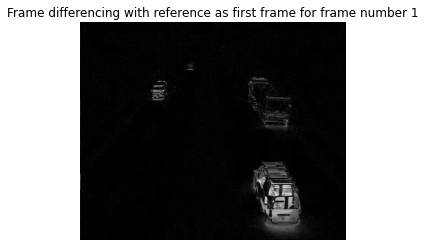

In [20]:
ICV_frame_difference_video(frames)

<b>b) Repeat the exercise using the previous frame as reference frame (use frame It-1 as reference frame for frame It, for each t). Comment the results in the report.</b>

In [ ]:
ICV_frame_difference_video_consecutive

<b>c) Write a function that generates a reference frame (background) for the sequence using for example frame differencing and a weighted temporal averaging algorithm</b>

In [ ]:
background = ICV_background(frames)
plt.axis("off")
plt.imshow(background, cmap = 'gray')

<b>d) Write a function that counts the number of moving objects in each frame of a sequence. Generate a bar plot that visualizes the number of objects for each frame of the whole sequence. Discuss in the report the implemented solution, including advantages and disadvantages.</b>

#### Attempt 1

In [ ]:
moving_objects = ICV_ICV_count_moving_objects_erosion_dilation(frames)

#### Attempt 2

In [ ]:
moving_objects = ICV_count_moving_objects_interpolation(frames)